In [1]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import torch

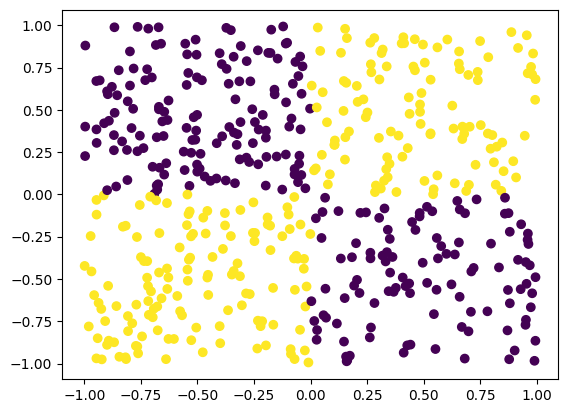

In [27]:
# make XOR gate dataset
N = 500
data = np.random.uniform(-1, 1, (N, 2))
label = np.zeros(N)
label[np.logical_and(data[:, 0] > 0, data[:, 1] > 0)] = 1
label[np.logical_and(data[:, 0] < 0, data[:, 1] < 0)] = 1
label[np.logical_and(data[:, 0] > 0, data[:, 1] < 0)] = 0
label[np.logical_and(data[:, 0] < 0, data[:, 1] > 0)] = 0

# plot the dataset

plt.scatter(data[:, 0], data[:, 1], c=label)
data = torch.tensor(data).float()
label = torch.tensor(label).float()


In [54]:

# make spiral data
# https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
N = 500
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
data_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
data_b = data_b + np.random.randn(N,2)

data = np.append(data_a, data_b, axis=0)
label = np.append(np.zeros(N), np.ones(N))

data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float().unsqueeze(1)

data.shape, label.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

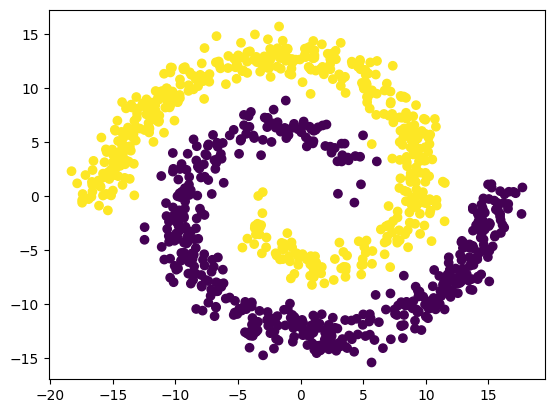

In [55]:
plt.scatter(data[:,0], data[:,1], c=label)

In [44]:
def visualize_decision_boundary(model, data, label):
  x_linspace = torch.linspace(min(data[:,0]), max(data[:,0]), steps=200)
  y_linspace = torch.linspace(min(data[:,1]), max(data[:,1]), steps=200)
  grid_x, grid_y = torch.meshgrid(x_linspace, y_linspace)
  grid_xy = torch.stack([grid_x, grid_y]).permute(1,2,0)
  grid_xy = grid_xy.view(-1, 2)
  value_by_grid = model(grid_xy)
  value_by_grid = value_by_grid.view(200, 200, 1)
  value_by_grid[value_by_grid<=0.5] = 0
  value_by_grid[value_by_grid>0.5] = 1

  plt.scatter(x=data[label[:,0]==0,0], y=data[label[:,0]==0,1])
  plt.scatter(x=data[label[:,0]==1,0], y=data[label[:,0]==1,1])

  plt.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), value_by_grid.detach().numpy().squeeze(), alpha=0.3)

In [8]:
torch.set_printoptions(sci_mode=False)

In [20]:
data.shape, label.shape

(torch.Size([500, 2]), torch.Size([500]))

In [12]:
data[:10]


tensor([[-0.0016, -0.9738],
        [-0.4083, -0.3713],
        [ 0.6800, -0.3641],
        [-0.5283, -0.9893],
        [ 0.3936,  0.7901],
        [ 0.6924, -0.8212],
        [-0.3318, -0.0437],
        [ 0.6469, -0.5488],
        [ 0.5917,  0.8849],
        [ 0.9046,  0.0275]], dtype=torch.float64)

In [14]:
label[:10]

tensor([1., 1., 0., 1., 1., 0., 1., 0., 1., 1.], dtype=torch.float64)

In [19]:
# Let's check how many different category exists in our label
# To count the number of unique element, you can use set()
label_list = label.tolist() # convert tensor to list
print(label_list[:10])
set(label_list)

[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]


{0.0, 1.0}

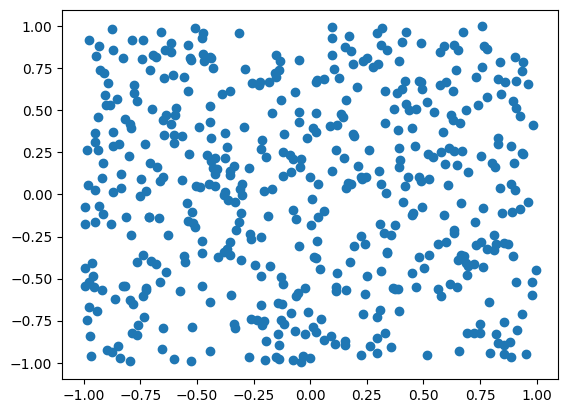

In [21]:
# scatter only for label 0

# first, plot the entire data
plt.scatter(x=data[:,0], y=data[:,1])

In [23]:
# using boolean
is_zero = label == 0
print(label[:10])
print(is_zero[:10])

tensor([1., 1., 0., 1., 1., 0., 1., 0., 1., 1.], dtype=torch.float64)
tensor([False, False,  True, False, False,  True, False,  True, False, False])


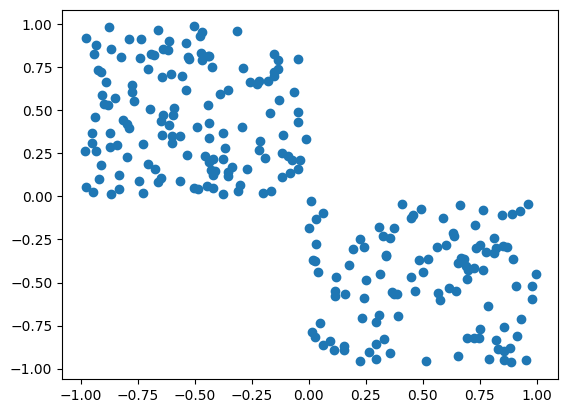

In [25]:
data_zero_class = data[is_zero] # you can index tensor using boolean tensor
plt.scatter(data_zero_class[:,0], data_zero_class[:,1])

In [60]:
# Let's make a model that takes 2D input, and returns 1D output
# f(x1, x2) -> y (between 0 and 1)
import torch.nn as nn

class MyModel(nn.Module):
  def __init__(self):
    super().__init__() # initialize the super class, nn.Module

    self.layer = nn.Linear(2, 32)
    self.layer2 = nn.Linear(32, 1)

  def forward(self, x): # in nn.Module, forward() is the fucntion when is called (__call__)
    return self.layer2(self.layer(x).relu()).sigmoid()


model = MyModel()
out = model(data)

data.shape, out.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [35]:
label = label.reshape(500, 1)

In [61]:
out[:10], label[:10], (out-label).abs()[:10]

(tensor([[0.4967],
         [0.4342],
         [0.5332],
         [0.0918],
         [0.6636],
         [0.3609],
         [0.6529],
         [0.6538],
         [0.4738],
         [0.5511]], grad_fn=<SliceBackward0>),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]),
 tensor([[0.4967],
         [0.4342],
         [0.5332],
         [0.0918],
         [0.6636],
         [0.3609],
         [0.6529],
         [0.6538],
         [0.4738],
         [0.5511]], grad_fn=<SliceBackward0>))

In [62]:

model = MyModel()
# define optimizer
# optimizer helps you to update the model's parameter
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # define what parameters we want to optimizer

for i in range(1000):
  # make prediction with current model
  pred = model(data)

  # calculate the loss
  loss = (pred - label).abs().mean()

  # backpropagate the loss
  loss.backward()

  # update the parameter
  optimizer.step()

  # reset the gradient
  # erase the old gradient
  optimizer.zero_grad()
  if (i % 100) == 0:  # for every 100 steps
    print(loss.item())


0.46666577458381653
0.2075968086719513
0.1300331950187683
0.12268688529729843
0.1056370958685875
0.013175025582313538
0.009491180069744587
0.008267031982541084
0.007621383760124445
0.007212641648948193


In [59]:
pred[-10:]

tensor([[0.8024],
        [0.9645],
        [1.0691],
        [1.0015],
        [0.9724],
        [0.9644],
        [1.0048],
        [1.1219],
        [1.0165],
        [0.9128]], grad_fn=<SliceBackward0>)

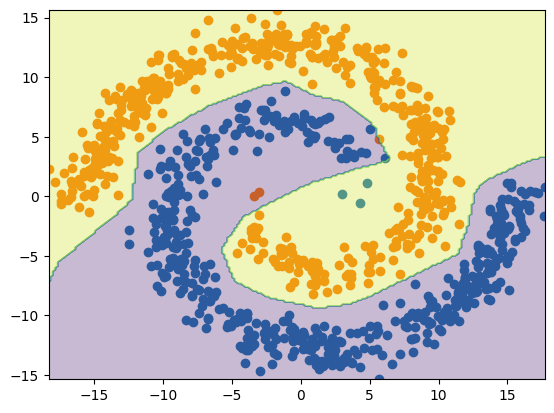

In [63]:
visualize_decision_boundary(model, data, label)
